In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import calendar
%matplotlib inline

calendar_boston = pd.read_csv('Boston_data/calendar.csv')
listings_boston = pd.read_csv('Boston_data/listings.csv')
reviews_boston = pd.read_csv('Boston_data/reviews.csv')

calendar_seattle = pd.read_csv('Seattle_data/calendar.csv')
listings_seattle = pd.read_csv('Seattle_data/listings.csv')
reviews_seattle = pd.read_csv('Seattle_data/reviews.csv')

### I'd like to answer the three inspiration questions from the Kaggle website data downloading page
- https://www.kaggle.com/datasets/airbnb/boston?resource=download
- https://www.kaggle.com/datasets/airbnb/seattle?select=reviews.csv

### 1. Can you describe the vibe of each Boston/Seattle neighborhood using listing descriptions?

#### Define some general functions

In [6]:
def get_sorted_data(df):
    """Get dataframe with sorted neighbourhood by median price in descending order
    Args:
      df: original listings data from Boston or Seattle
      
    Returns:
      df_sorted: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      sorted_neighbors_values: array of sorted median prices
    """
    # Remove the $ sign in the price column and save as new column "price_value"
    df["price_value"] = pd.to_numeric(df.price.str[1:], errors='coerce')
    sorted_neighbors = df.groupby("neighbourhood_cleansed").median()["price_value"].sort_values(ascending=False).index
    sorted_neighbors_values = df.groupby("neighbourhood_cleansed").median()["price_value"].sort_values(ascending=False).values

    df_sorted = pd.DataFrame()
    for neighbor in sorted_neighbors:
        df_sorted = pd.concat([df_sorted, df.loc[df.neighbourhood_cleansed == neighbor, :]], axis=0)
    
    return df_sorted, sorted_neighbors, sorted_neighbors_values


def add_n_obs(plt, df, sorted_neighbors, group_col, y, textPos=600):
    '''Add N Obs on the price vs. neighborhood boxplot
    Args:
      plt: current plot handle on which numbers of observations are to be added
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      group_col: categorical groups for the boxplot
      y: continuous variable for the boxplot
      textPos: The Y axis positions to add numbers of observations
      
    Returns:
      None
    '''
    yticklabels = [y.get_text() for y in plt.gca().get_yticklabels()]
    n_obs = df.groupby(group_col)[y].size().loc[sorted_neighbors]
    for (y, yticklabel), n_ob in zip(enumerate(yticklabels), n_obs):
        plt.text(textPos, y, "#obs: "+str(n_ob), verticalalignment='center', fontdict={'size':14}, color='red')
        

def boxplot_neighbor_vs_medianPrice(df, sorted_neighbors, title, width, height):
    '''Generate boxplot of price by neighbourhood, with neighbourhood in descending order of median price
    Args:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      title: plot title
      width: plot width
      height: plot height
      
    Returns:
      None
    '''
    plt.figure(figsize=(width, height))
    sns.set_style("whitegrid")
    sns.boxplot(x='price_value', y='neighbourhood_cleansed', data=df, orient="h")
    add_n_obs(plt, df, sorted_neighbors, group_col='neighbourhood_cleansed', y='price_value', textPos=600)
    plt.title(title, fontsize=16)
    

def scatterplot_percentageEntireHome_vs_medianPrice(df, sorted_neighbors, sorted_neighbors_values, title):
    '''Generate scatterplot of median price vs. percentage of entire home/apt
    Args:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      sorted_neighbors_values: array of sorted median prices
      title: plot title
      
    Returns:
      None. Only Spearman correlation is printed on the screen
    '''
    percentage_entire_home = []
    for col in sorted_neighbors:
        tbl = df[df.neighbourhood_cleansed == col].room_type.value_counts()
        percentage_entire_home.append(round(tbl["Entire home/apt"]/tbl.sum() * 100, 2))
    
    df = pd.DataFrame({
        'sorted_neighbors_values': sorted_neighbors_values,
        'percentage_entire_room': percentage_entire_home
    })
    sns.lmplot(x="sorted_neighbors_values", y="percentage_entire_room", data=df)
    spearman_rho = round(df.corr(method="spearman").loc['percentage_entire_room', 'sorted_neighbors_values'], 2)
    plt.xlabel('Median Neighboring Price')
    plt.ylabel('Percentge of Entire Home/Apt in All Room Type')
    plt.suptitle(title, y=1.08, fontsize=14)
    plt.title('Spearman Correlation = ' + str(spearman_rho), fontsize=12)
    

def stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df, sorted_neighbors, title, width, height):
    '''Generate stacked bar plot of percentage of property type by neighbourhood
    Args:
      df: sorted listing data with neighbors sorted by median listing price from high to low
      sorted_neighbors: index of the sorted neighbors by median prices
      title: plot title
      width: plot width
      height: plot height
      
    Returns:
      None
    '''
    df['temp_value'] = 1
    df = df[['neighbourhood_cleansed', 'property_type', 'temp_value']]
    df_wide = df.pivot_table(index='neighbourhood_cleansed', columns='property_type', values='temp_value', aggfunc = 'sum', fill_value = 0)
    df_wide = df_wide.apply(lambda x: x / x.sum() * 100, axis=1).loc[sorted_neighbors, :]

    df_wide.plot(kind="bar", stacked=True, figsize=(width,height))
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(title, fontsize=16)


#### 1.1 Generate boxplot of price by neighbourhood, with neighbourhood in descending order of median price

25


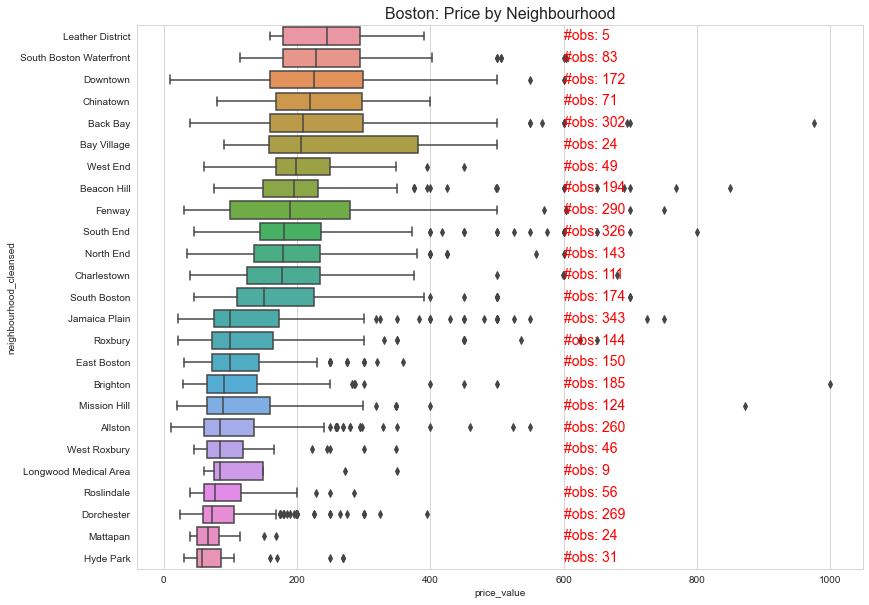

In [7]:
df_boston, sorted_neighbors_boston, sorted_neighbors_values_boston = get_sorted_data(listings_boston)
print(len(sorted_neighbors_boston))
boxplot_neighbor_vs_medianPrice(df_boston, sorted_neighbors_boston,
                                title="Boston: Price by Neighbourhood", width=13, height=10)

87


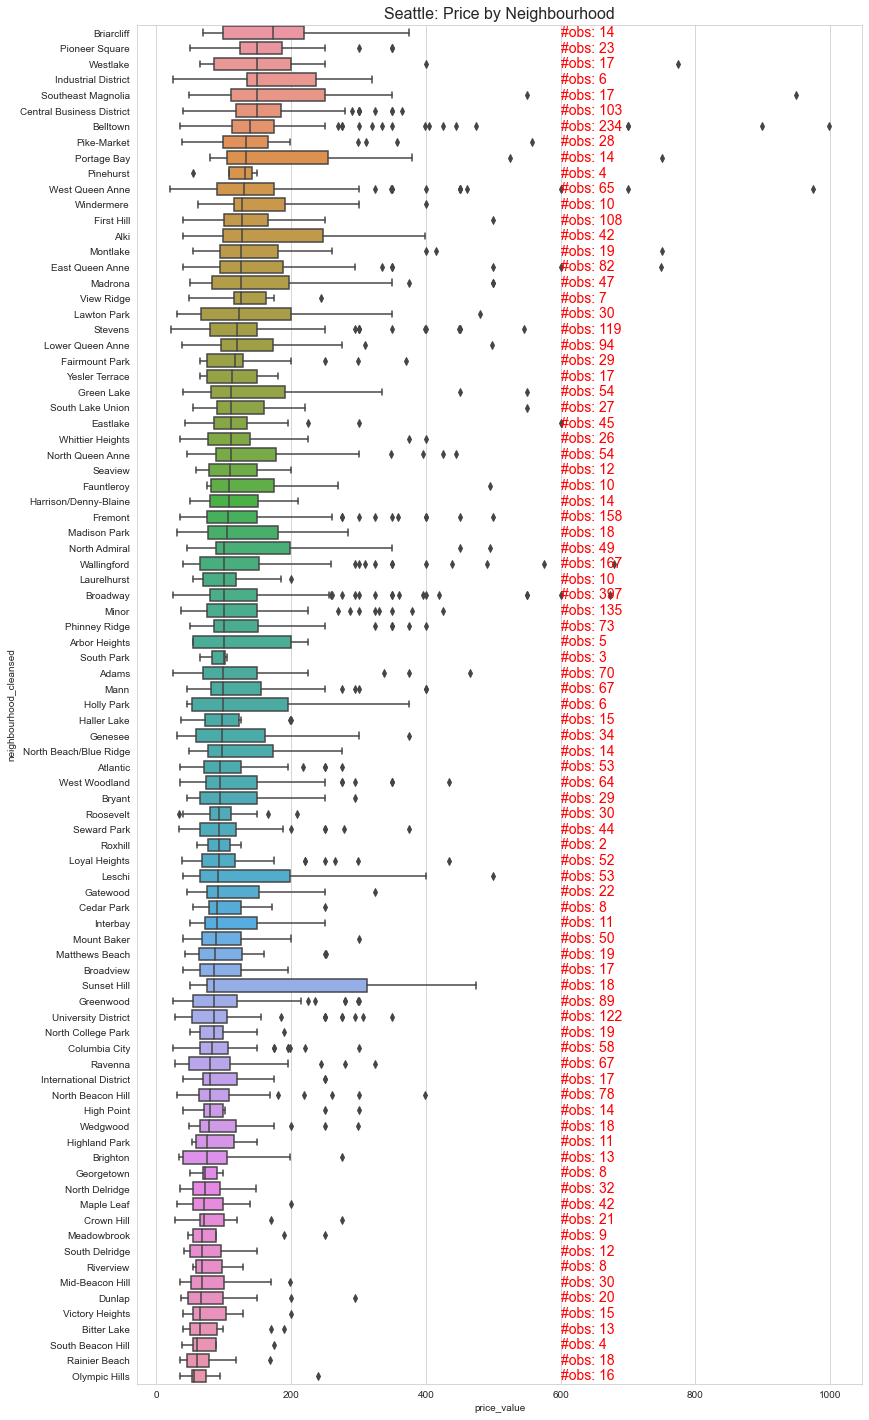

In [8]:
df_seattle, sorted_neighbors_seattle, sorted_neighbors_values_seattle = get_sorted_data(listings_seattle)
print(len(sorted_neighbors_seattle))
boxplot_neighbor_vs_medianPrice(df_seattle, sorted_neighbors_seattle,
                                title="Seattle: Price by Neighbourhood", width=13, height=25)

#### 1.2 Generate scatterplot of median price vs. percentage of entire home/apt

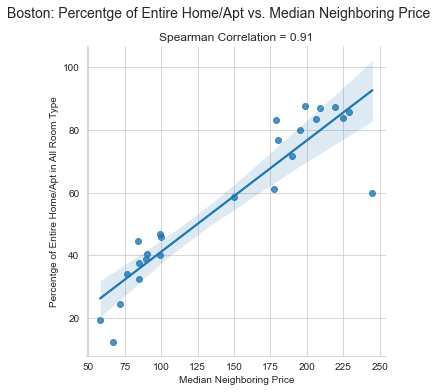

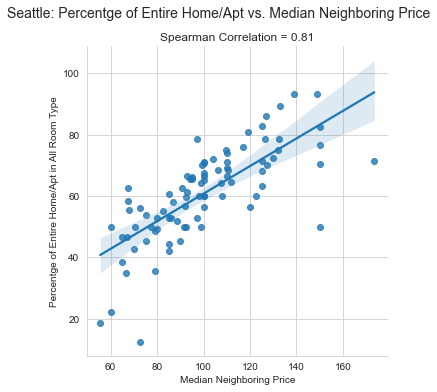

In [9]:
scatterplot_percentageEntireHome_vs_medianPrice(df_boston, sorted_neighbors_boston, sorted_neighbors_values_boston,
                                                title='Boston: Percentge of Entire Home/Apt vs. Median Neighboring Price')

scatterplot_percentageEntireHome_vs_medianPrice(df_seattle, sorted_neighbors_seattle, sorted_neighbors_values_seattle,
                                                title='Seattle: Percentge of Entire Home/Apt vs. Median Neighboring Price')


#### 1.3 Generate stacked bar plot of percentage of property type by neighbourhood

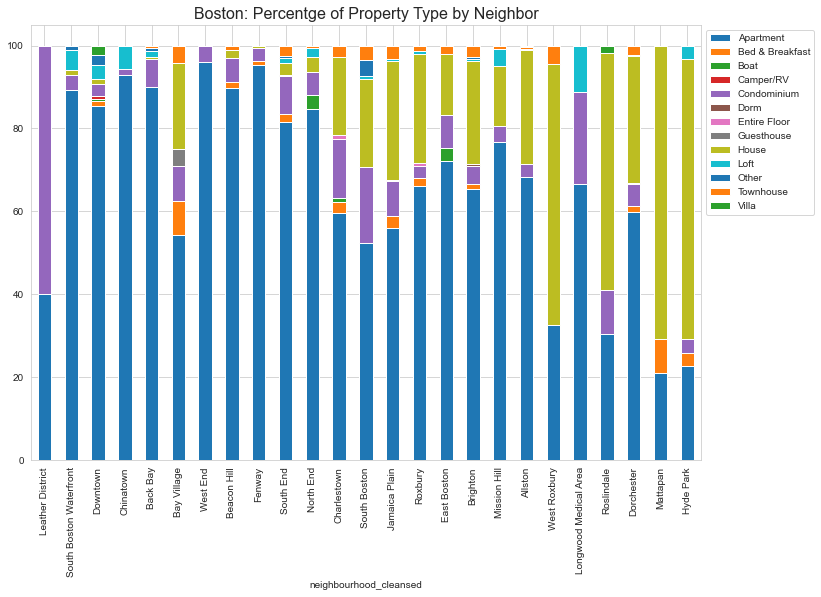

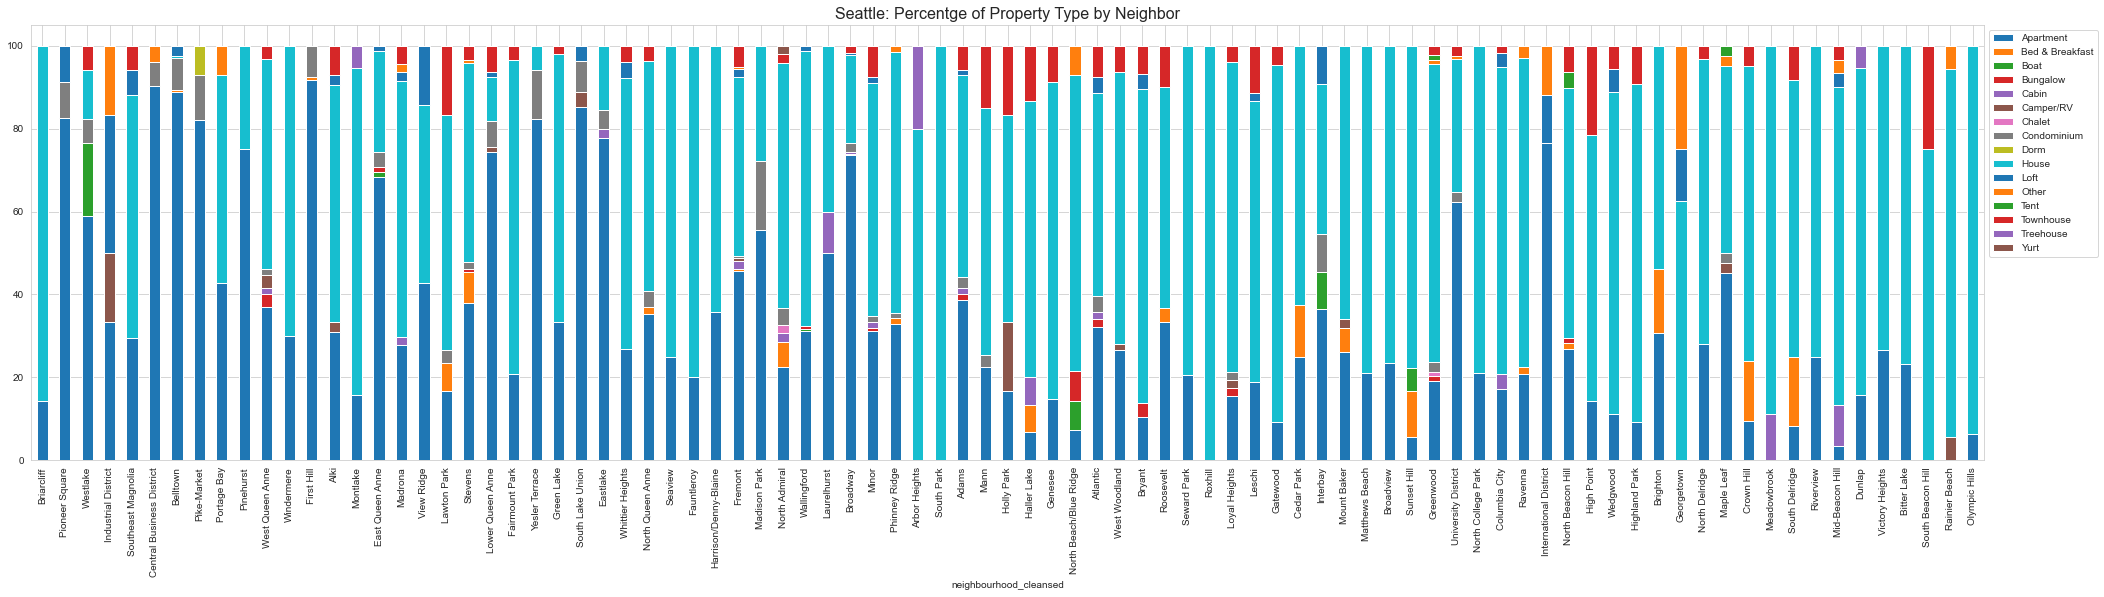

In [10]:
stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df_boston, sorted_neighbors_boston,
                                                       title='Boston: Percentge of Property Type by Neighbor',
                                                       width=12, height=8)

stackedbarplot_percentagePropertyTypes_vs_neighbourhood(df_seattle, sorted_neighbors_seattle,
                                                       title='Seattle: Percentge of Property Type by Neighbor',
                                                       width=35, height=8)

#### 2. What are the busiest times of the year to visit Boston/Seattle? By how much do prices spike?

#### Define some general functions

In [13]:
sorted_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def barplot_percentageAvailability_vs_month(df, title, width, height, color):
    '''Generate bar plot of percentage of availability by month
    Args:
      df: preprocessed calendar dataframe from Boston or Seattle
      title: plot title
      width: plot width
      height: plot height
      color: bar color
      
    Returns:
      None
    '''
    df['temp_value'] = 1
    df = df[['month_abbrs', 'available', 'temp_value']]
    df_wide = df.pivot_table(index='month_abbrs', columns='available', values='temp_value', aggfunc = 'sum', fill_value = 0)
    df_wide = df_wide.apply(lambda x: x / x.sum() * 100, axis=1).loc[sorted_months, 't']
    df_wide.plot(kind="bar", color=color, figsize=(width,height))
    plt.title(title, fontsize=16)

def lineplot_price_vs_month(df, title, width, height, color):
    '''Generate line plot of median listing price by month
    Args:
      df: preprocessed calendar dataframe from Boston or Seattle with listings available
      title: plot title
      width: plot width
      height: plot height
      color: line color
      
    Returns:
      None
    '''
    df = df.copy()
    df["price_value"] = pd.to_numeric(df.price.str[1:], errors='coerce')
    df = df[['month_abbrs', 'available', 'price_value']]
    df_wide = df.pivot_table(index='month_abbrs', columns='available', values='price_value', aggfunc = 'median', fill_value = 0)
    df_wide = df_wide.loc[sorted_months, :]
    df_wide.plot(kind="line", color=color, figsize=(width,height))
    plt.title(title, fontsize=16)
    plt.legend('')

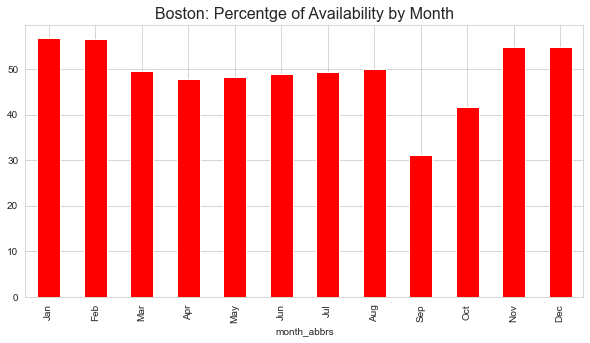

In [14]:
# Extract numeric month from the date column with format 'mm/dd/yyyy' and save as column 'month_numbers'
calendar_boston["month_numbers"] = [int(ele.lstrip('0')) for ele in calendar_boston.date.str[5:7]]

# Transform numeric month to abbreviations and save as column 'month_abbrs'
calendar_boston["month_abbrs"] = [calendar.month_abbr[month_number] for month_number in calendar_boston["month_numbers"]]

barplot_percentageAvailability_vs_month(calendar_boston, 
                                        title='Boston: Percentge of Availability by Month', width=10, height=5, color='red')

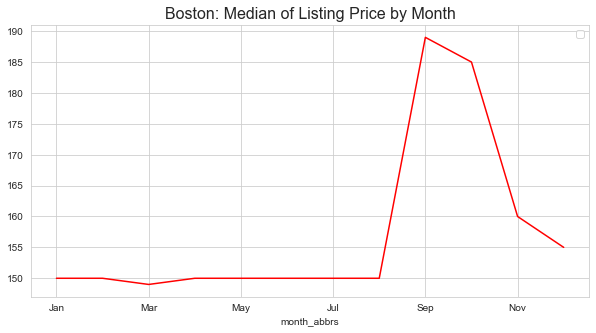

In [15]:
lineplot_price_vs_month(calendar_boston[calendar_boston.available == 't'],
                        title='Boston: Median of Listing Price by Month', width=10, height=5, color='red')

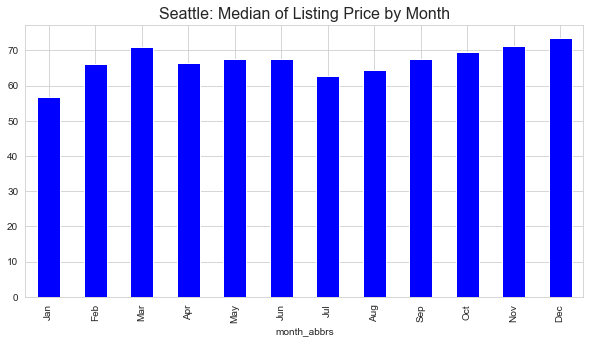

In [16]:
calendar_seattle["month_numbers"] = [int(ele.lstrip('0')) for ele in calendar_seattle.date.str[5:7]]
calendar_seattle["month_abbrs"] = [calendar.month_abbr[month_number] for month_number in calendar_seattle["month_numbers"]]
barplot_percentageAvailability_vs_month(calendar_seattle, 
                                        title='Seattle: Median of Listing Price by Month', width=10, height=5, color='blue')

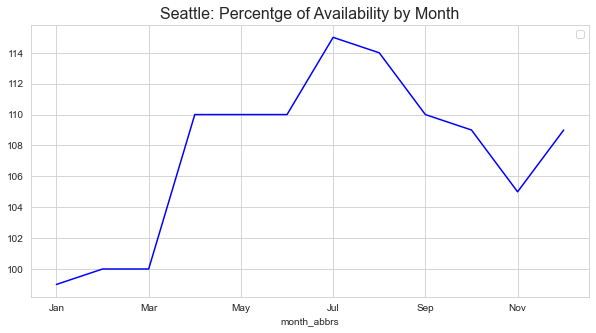

In [17]:
lineplot_price_vs_month(calendar_seattle[calendar_seattle.available == 't'],
                        title='Seattle: Percentge of Availability by Month', width=10, height=5, color='blue')

#### 3. Is there a general upward trend of new Airbnb listings to Boston/Seattle?

#### Define some general functions

In [18]:
def lineplot_newListings(df1, df2, title):
    '''Generate line plot for number of new listings by month
    Args:
      df1: 1st listing dataframe (Boston data)
      df2: 2nd listing dataframe (Seattle adata)
      title: plot title
      
    Returns:
      None
    '''
    df1['host_since_year'] = [ele for ele in df1.host_since.str[0:4]]
    df2['host_since_year'] = [ele for ele in df2.host_since.str[0:4]]
    values1 = df1['host_since_year'].value_counts().loc[::-1]
    values2 = df2['host_since_year'].value_counts().loc[::-1]
    plt.figure(figsize=(8,5))
    plt.plot(values1.sort_index(), label='Boston', color='red')
    plt.plot(values2.sort_index(), label='Seattle', color='blue')
    plt.legend()
    plt.title(title)

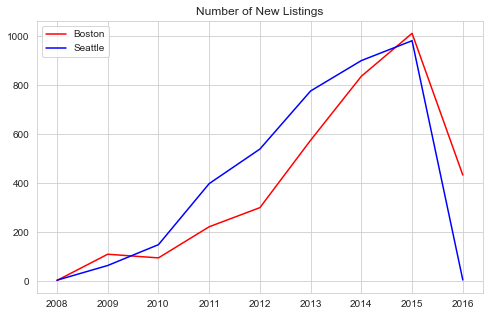

In [19]:
lineplot_newListings(listings_boston, listings_seattle, 'Number of New Listings')